# Module 9 - Programming Assignment

## Directions

1. Change the name of this file to be your JHED id as in `jsmith299.ipynb`. Because sure you use your JHED ID (it's made out of your name and not your student id which is just letters and numbers).
2. Make sure the notebook you submit is cleanly and fully executed. I do not grade unexecuted notebooks.
3. Submit your notebook back in Blackboard where you downloaded this file.

*Provide the output **exactly** as requested*

## Naive Bayes Classifier

For this assignment you will be implementing and evaluating a Naive Bayes Classifier with the same data from last week:

http://archive.ics.uci.edu/ml/datasets/Mushroom

(You should have downloaded it).

<div style="background: lemonchiffon; margin:20px; padding: 20px;">
    <strong>Important</strong>
    <p>
        No Pandas. The only acceptable libraries in this class are those contained in the `environment.yml`. No OOP, either. You can used Dicts, NamedTuples, etc. as your abstract data type (ADT) for the the tree and nodes.
    </p>
</div>


You'll first need to calculate all of the necessary probabilities using a `train` function. A flag will control whether or not you use "+1 Smoothing" or not. You'll then need to have a `classify` function that takes your probabilities, a List of instances (possibly a list of 1) and returns a List of Tuples. Each Tuple has the best class in the first position and a dict with a key for every possible class label and the associated *normalized* probability. For example, if we have given the `classify` function a list of 2 observations, we would get the following back:

```
[("e", {"e": 0.98, "p": 0.02}), ("p", {"e": 0.34, "p": 0.66})]
```

when calculating the error rate of your classifier, you should pick the class label with the highest probability; you can write a simple function that takes the Dict and returns that class label.

As a reminder, the Naive Bayes Classifier generates the *unnormalized* probabilities from the numerator of Bayes Rule:

$$P(C|A) \propto P(A|C)P(C)$$

where C is the class and A are the attributes (data). Since the normalizer of Bayes Rule is the *sum* of all possible numerators and you have to calculate them all, the normalizer is just the sum of the probabilities.

You will have the same basic functions as the last module's assignment and some of them can be reused or at least repurposed.

`train` takes training_data and returns a Naive Bayes Classifier (NBC) as a data structure. There are many options including namedtuples and just plain old nested dictionaries. **No OOP**.

```
def train(training_data, smoothing=True):
   # returns the Decision Tree.
```

The `smoothing` value defaults to True. You should handle both cases.

`classify` takes a NBC produced from the function above and applies it to labeled data (like the test set) or unlabeled data (like some new data). (This is not the same `classify` as the pseudocode which classifies only one instance at a time; it can call it though).

```
def classify(nbc, observations, labeled=True):
    # returns a list of tuples, the argmax and the raw data as per the pseudocode.
```

`evaluate` takes a data set with labels (like the training set or test set) and the classification result and calculates the classification error rate:

$$error\_rate=\frac{errors}{n}$$

Do not use anything else as evaluation metric or the submission will be deemed incomplete, ie, an "F". (Hint: accuracy rate is not the error rate!).

`cross_validate` takes the data and uses 10 fold cross validation (from Module 3!) to `train`, `classify`, and `evaluate`. **Remember to shuffle your data before you create your folds**. I leave the exact signature of `cross_validate` to you but you should write it so that you can use it with *any* `classify` function of the same form (using higher order functions and partial application). If you did so last time, you can reuse it for this assignment.

Following Module 3's discussion, `cross_validate` should print out the fold number and the evaluation metric (error rate) for each fold and then the average value (and the variance). What you are looking for here is a consistent evaluation metric cross the folds. You should print the error rates in terms of percents (ie, multiply the error rate by 100 and add "%" to the end).

To summarize...

Apply the Naive Bayes Classifier algorithm to the Mushroom data set using 10 fold cross validation and the error rate as the evaluation metric. You will do this *twice*. Once with smoothing=True and once with smoothing=False. You should follow up with a brief explanation for the similarities or differences in the results.

### Begin with data parsing functions
The functions `parse_data(file_name: str, shuffle_ = False)`, `create_folds(xs: List, n: int)`, and `create_train_test(folds: List[List[List]], index: int)` are fetched directly from the functions provided in Module 3's prgramming assignment and will be used to parse and process the data.

In [1]:
from typing import List, Dict, Tuple, Callable
from copy import deepcopy
from random import shuffle
from matplotlib import pyplot as plt

In [2]:
def parse_data(file_name: str, shuffle_ = False) -> []:
    data = []
    file = open(file_name, "r", encoding='utf-8-sig')
    for line in file:
        datum = [value for value in line.rstrip().split(",")]
        data.append(datum)
    if shuffle_:
        shuffle(data)
    return data

def create_folds(xs: List, n: int) -> List[List[List]]:
    k, m = divmod(len(xs), n)
    # be careful of generators...
    return list(xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

def create_train_test(folds: List[List[List]], index: int) -> Tuple[List[List], List[List]]:
    training = []
    test = []
    for i, fold in enumerate(folds):
        if i == index:
            test = fold
        else:
            training = training + fold
    return training, test

def mean(list_: list) -> float:
    mean_value = sum([val for val in list_])/len(list_)
    return mean_value

def variance(values: list):
    mean_value = mean(values)
    variance = sum([(val-mean_value)**2 for val in values])/(len(values)-1)
    return variance

In [3]:
sc_data = parse_data('SelfCheckData.csv')
sc_data

[['round', 'large', 'blue', 'no'],
 ['square', 'large', 'green', 'yes'],
 ['square', 'small', 'red', 'no'],
 ['round', 'large', 'red', 'yes'],
 ['square', 'small', 'blue', 'no'],
 ['round', 'small', 'blue', 'no'],
 ['round', 'small', 'red', 'yes'],
 ['square', 'small', 'green', 'no'],
 ['round', 'large', 'green', 'yes'],
 ['square', 'large', 'green', 'yes'],
 ['square', 'large', 'red', 'no'],
 ['square', 'large', 'green', 'yes'],
 ['round', 'large', 'red', 'yes'],
 ['square', 'small', 'red', 'no'],
 ['round', 'small', 'green', 'no']]

### `train(data, target_variable, normalize=True)`
`train(data, target_variable, normalize=True)` uses `data` and the index `target_variable` to construct:
1. A frequency dictionary with all the features and the labels associated with them. The objective is to count for a give feature and label, the number of appearances in `data`. 
2. A frequency dictionary for the different labels on the target variable. 
3. From steps 1 and 2 above we can construct probability tables. `normalize` implements +1 normalization on observations in which a given feature may not have any label appearances. This avoids having division by zero erros.

The function returns a tuple. The first element of said tuple corresponds to the conditional probability dictionary which has all the feature and label wise conditional probabilities. The second element of the tuple is an overall label probability dictionary. We will later on use these two dictionaries to compute a Naive Bayes Probability estimate. 

In [4]:
def train(data, target_variable, smooth=True):
    
    feature_variables = [feature for feature in range(len(data[0])) if feature != target_variable]
    n = len(data)
    
    frequency_table = {}
    target_variable_fequency = {}
    for row in range(len(data)):
        if data[row][target_variable] not in target_variable_fequency:
            target_variable_fequency[data[row][target_variable]] = 1
        else:
            target_variable_fequency[data[row][target_variable]] += 1
        for feature in feature_variables:
            if feature not in frequency_table:
                frequency_table[feature] = {}
            if data[row][feature] not in frequency_table[feature]:
                frequency_table[feature][data[row][feature]] = {}
            if data[row][target_variable] not in frequency_table[feature][data[row][feature]]:
                frequency_table[feature][data[row][feature]][data[row][target_variable]] = 1
                continue
            frequency_table[feature][data[row][feature]][data[row][target_variable]] += 1
            
    probability_table = deepcopy(frequency_table)
    for feature in probability_table:
        for label in probability_table[feature]:
            for frequency in probability_table[feature][label]:
                numerator = deepcopy(probability_table[feature][label][frequency])
                numerator = numerator + 1 if smooth else numerator
                denominator = deepcopy(target_variable_fequency[frequency])
                denominator = denominator + 1 if smooth else denominator            
                probability_table[feature][label][frequency] = numerator / denominator 

            for target_label in target_variable_fequency:
                if target_label not in probability_table[feature][label]:
                    numerator = 1 if smooth else 0 
                    denominator = deepcopy(target_variable_fequency[target_label])
                    denominator = denominator + 1 if smooth else denominator
                    probability_table[feature][label][target_label] = numerator / denominator
                    
    target_variable_probability = {label:target_variable_fequency[label]/n for label in target_variable_fequency}
    
    return probability_table, target_variable_probability

In [5]:
probability_table, target_variable_probability = train(sc_data, 3, smooth=True)

In [6]:
# This example follows from this week's Self Check.
assert probability_table == {0: {'round': {'no': 0.4444444444444444, 'yes': 0.625},
                                 'square': {'yes': 0.5, 'no': 0.6666666666666666}},
                             1: {'large': {'no': 0.3333333333333333, 'yes': 0.875},
                                 'small': {'no': 0.7777777777777778, 'yes': 0.25}},
                             2: {'blue': {'no': 0.4444444444444444, 'yes': 0.125},
                                 'green': {'yes': 0.625, 'no': 0.3333333333333333},
                                 'red': {'no': 0.4444444444444444, 'yes': 0.5}}}

assert target_variable_probability == {'no': 0.5333333333333333, 'yes': 0.4666666666666667}

### `classify_instance(probability_table, target_variable_probability, instance, target_variable)`
Up to now we have a function which produces the estimated conditional probabilities and the probabilities of the labels.The function `classify_instance` takes in those two elements, a single `instance` in the form of a list, and the index as an integer of the `target_variable` to classify such instance provided the individual features of the `instance`.
The function implements the formula given in this week's pseudocode:

$$
label = \text{argmax}_{c \in C} \mathbb{P}(c) \Pi_{i,j} \mathbb{P}(a_i=v_j|c)
$$

For this to occur, we need to generate estimates for the different labels and the return the one `label` for which the estimated value is higher. In order to do so, we look through the keys in `target_variable_probability` and then traverse through the values of `instance`, fetching the corresponding conditional probability from `probability_table`given the value of `label`. Store these estimates in a list and then sort the list in ascending order. The returned value is a tuple including the argmax label, and then the list of the values estimated along with its corresponding probabilities. 

The function returns a tuple which contains in its first place the best label and in its second place a dictionary of the normalized probabilities. The probabilities are normalized by adding the individual label probabilities and using that value as a denominator. Then the individual probabilities are divided by the value of the total probabilities. 

In [7]:
def classify_instance(probability_table, target_variable_probability, instance, target_variable):
    results = []
    total_probability = 0 
    for label in target_variable_probability:
        cond_prob = target_variable_probability[label]
        attributes = [f for f in range(len(instance)) if f != target_variable]
        for feature in attributes:
            cond_prob *= probability_table[feature][instance[feature]][label]
        results.append((label, cond_prob))
        total_probability += cond_prob
    results.sort(key=lambda x: x[1],reverse=True)
    results_dict = {r[0]:r[1]/total_probability for r in results}
    return (results[0][0], results_dict)

In [8]:
# This example follows from this week's Self Check.
instance = ['square', 'large', 'red',]
assert classify_instance(probability_table, target_variable_probability, instance, 3) == \
                                                ('yes', {'yes': 0.6596310453714476, 'no': 0.3403689546285523})

### classify(probability_table, target_variable_probability, observations, target_variable)
`classify(probability_table, target_variable_probability, observations, target_variable)` is a wrapper function for `classify_instance()` in which the we loop through a list of instance `observations`. The function returns a list of `results` instead of a single result as in the case of `classify_instance()`.

In [9]:
def classify(probability_table, target_variable_probability, observations, target_variable):
    results = []
    for ob in range(len(observations)):
        results.append(classify_instance(probability_table, target_variable_probability, observations[ob],target_variable))
    return results

In [10]:
# This example follows from this week's Self Check.
# I have added the second observation for completeness.
observations = [['square', 'large', 'red'],['round', 'small', 'blue']]
classify(probability_table, target_variable_probability, observations,3)
assert classify(probability_table, target_variable_probability, observations,3) == \
[('yes', {'yes': 0.6596310453714476, 'no': 0.3403689546285523}),
 ('no', {'no': 0.8998983879383737, 'yes': 0.10010161206162636})]

### `evaluate(probability_table, target_variable_probability, evaluation_data, target_variable)`
`evaluate()` uses the functions and methods defined and implemented up to now to produce an error rate of the form 
$$
\text{error rate} = \frac{errors}{n}
$$
Where $errors$ corresponds to the total number of classifications in which the classified value is different from the actually observed target value. $n$ corresponds to the number of elements in `evaluation_data`.

The function uses the classification elements of the NBC `probability_table` and `target_variable_probability` to call the `classify()` function and produce a list of classifications. This estimates are the compared to the actual observed values and the **error rate** is finally computed and returned.

In [11]:
def evaluate(probability_table, target_variable_probability, evaluation_data, target_variable):    
    attributes = [attr for attr in range(len(evaluation_data[0])) if attr != target_variable]    
    evaluation_target = [row[target_variable] for row in evaluation_data]    
    evaluation_features = [[row[atr] for atr in attributes] for row in evaluation_data]    
    evaluation_classification = classify(probability_table, target_variable_probability, evaluation_data, target_variable)
    evaluation_classification = [row[0] for row in evaluation_classification]
    n = len(evaluation_target)
    error = sum([evaluation_target[i]!=evaluation_classification[i] for i in range(n)])
    return error/n

In [12]:
# This example follows from this week's Self Check.
evaluation_data = deepcopy(sc_data)
assert evaluate(probability_table, target_variable_probability, evaluation_data, 3) == 0.13333333333333333

### `cross_validate(data, target_attribute)`
`cross_validate(data, target_attribute)` follows the same procedures implemented in modules 3 and 8. As a summary, the function follows the following steps:
1. Use the already shuffled `data` source to
2. split the dataset into `k-folds` using the `create_folds()` function.
3. For each unique fold:
    - Split the fold into a `training` and `test` set using the `create_train_test()` function.
    - Use a base model to compare against a trivial guess. In this case, we will choose arbitrarily the first label on the test set across the entire set as the baseline model. Then store an evaluation metric for the base model. 
    - Fit a model on the `training` set and evaluate it on the `test` set.
    - Retain the evaluation score and discard the model.
4. Summarize the skill of the model using the sample of the evaluation scores. We will also compare the summary statistics of the model agains the base model.

The function produces a table with the error rates for all `k-folds` in both the NBC classifier and the Base model. Then we print out the mean and variance of the estimates. Finally a graph is printed for a visual representation of the data.

In [13]:
def cross_validate(data, target_attribute, k_folds = 10, smooth=True):
    fold_label = 'Fold'
    knn_mse_label = 'NBC(%)'
    base_mse_label = 'Base(%)'
    mean_label = "Mean"
    variance_label = 'Var.'

    folds = create_folds(data, k_folds)
    base_errors = []
    model_errors = []
    tree = None
    print(f'Error Rate by Fold: {"Smoothed" if smooth else ""} NBC Vs. Base')
    print(f"""{fold_label : <5}{knn_mse_label : ^15}{base_mse_label : >10}""")
    for i in range(len(folds)):
        training, test = create_train_test(folds, i)    
        y = [sample[target_attribute] for sample in test]       

        base_y_hat = [test[0][target_attribute] for sample in test]
        base_error = sum([y[i] != base_y_hat[i] for i in range(len(test))])
        base_error_rate = base_error/len(test)
        base_errors.append(base_error_rate)   

        probability_table, target_variable_probability = train(training, target_attribute, smooth=smooth)
        error_rate = evaluate(probability_table, target_variable_probability, training, target_attribute)
        model_errors.append(error_rate)

        print(f"""{i+1 : <5}{error_rate*100 : ^15.2f}{base_error_rate*100 : >10.2f}""")

    base_mean = mean(base_errors)
    model_mean = mean(model_errors)
    print(f"""{mean_label : <5}{model_mean*100 : ^15.2f}\
    {base_mean*100 : >6.2f}""")

    base_variance = variance([error*100 for error in base_errors])
    model_variance = variance([error*100 for error in model_errors])

    print(f"""{variance_label : <5}{model_variance : ^15.2f}\
    {base_variance : >6.2f}""")
        
    fig = plt.figure(figsize=(10, 7))
    plt.plot(range(1,len(model_errors)+1),model_errors, label='Model Error Rates')
    plt.plot(range(1,len(base_errors)+1),base_errors, label = 'Base Error Rates')
    plt.xlabel("Fold")
    plt.ylabel("Error Rate")
    plt.legend(fontsize=12)
    plt.title(f'{"Smoothed" if smooth else ""} NBC Error Rates vs. Base Error Rates')
    plt.show()

Error Rate by Fold: Smoothed NBC Vs. Base
Fold     NBC(%)        Base(%)
1         4.58           47.11
2         4.45           47.60
3         4.43           48.59
4         4.64           49.69
5         4.27           54.43
6         4.50           47.78
7         4.60           47.41
8         4.21           49.14
9         4.43           48.15
10        4.50           53.82
Mean      4.46           49.37
Var.      0.02            6.92


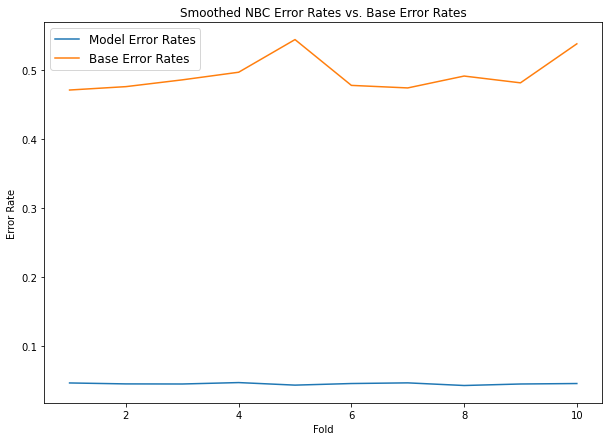

In [14]:
mushroom_data = parse_data('agaricus-lepiota.data', True)
cross_validate(mushroom_data, 0, 10, True)

Error Rate by Fold:  NBC Vs. Base
Fold     NBC(%)        Base(%)
1         0.33           47.11
2         0.27           47.60
3         0.29           48.59
4         0.34           49.69
5         0.29           54.43
6         0.30           47.78
7         0.31           47.41
8         0.19           49.14
9         0.27           48.15
10        0.30           53.82
Mean      0.29           49.37
Var.      0.00            6.92


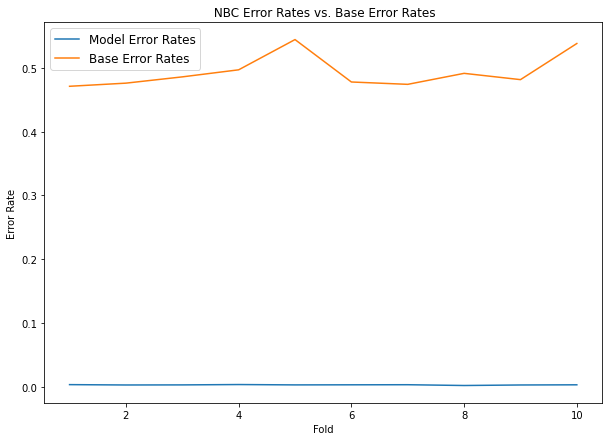

In [15]:
cross_validate(mushroom_data, 0, 10, False)

## Before You Submit...

1. Did you provide output exactly as requested?
2. Did you re-execute the entire notebook? ("Restart Kernel and Rull All Cells...")
3. If you did not complete the assignment or had difficulty please explain what gave you the most difficulty in the Markdown cell below.
4. Did you change the name of the file to `jhed_id.ipynb`?

Do not submit any other files.